In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import seaborn as sns
import h5py
import tqdm
import zipfile 
from tqdm.notebook import tqdm_notebook
from progress.bar import IncrementalBar
import copy
import random
import pandas as pd
import time
import os
import math
from joblib import Parallel, delayed
import importlib

# tf.config.run_functions_eagerly(True)
%matplotlib inline
np.set_printoptions(suppress=True)

In [2]:
param_names=['signal','pl_fr','real_wf-pl_fr','mask']

In [3]:
def norming(data,param_names=param_names,log=True):
    
    # ADD LOGARIFM FOR SIGNAL
    norm_params={}
    for i in range(data.shape[-1]):
        if (i==0 and log):
            data[:,:,:,i]=tf.math.log(data[:,:,:,i]+1)
        max_c=data[:,:,:,i].max()
        min_c=data[:,:,:,i].min()
        mean_c=data[:,:,:,i].mean()
        std_c=data[:,:,:,i].std()
        print(max_c,min_c)
        data[:,:,:,i]=(data[:,:,:,i]-min_c)/(max_c-min_c)

        norm_params[param_names[i]]=np.array([max_c,min_c])
    return norm_params
def renormin(data_not_change,norm_params,param_names=param_names,log=True):
    data=np.copy(data_not_change)
    for i in range(data.shape[-1]):
        max_c, min_c=norm_params[param_names[i]]
        data[:,:,:,i]=data[:,:,:,i]*(max_c-min_c) + min_c
        if (i==0 and log):
            data[:,:,:,i]=tf.math.exp(data[:,:,:,i])-1
        elif (i==1 or i==2):
            data[:,:,:,i]=data[:,:,:,i]*1e6
    return data

In [8]:
path = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
num=2000
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    dt_bunlde_mask = f['dt_bunlde_mask'][:num]
# norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_bunlde_mask', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(2000, 6, 6, 4)


In [30]:
path = '../../data_01_24.h5'
num=2000
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    dt_bunlde_mask = f['dt_bunlde_mask'][:num]
# norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)

OSError: Unable to open file (unable to open file: name = '../../data_01_24.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Constant

In [7]:
import tensorflow as tf
import math
pi = tf.constant(math.pi,dtype=tf.float32)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= tf.constant(1e9/c,dtype=tf.float32)# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=tf.constant(30e-3,dtype=tf.float32)#
LINSLEY_r0=tf.constant(25,dtype=tf.float32)#
DET_AREA=tf.constant(3,dtype=tf.float32)#
s_min = tf.constant([[0.3]],dtype=tf.float32)
s_max = tf.constant([[1.8]],dtype=tf.float32)
t_err_res=tf.constant(c/1e6,dtype=tf.float32)#
t0_err=tf.constant(30,dtype=tf.float32)#
dist=tf.constant(1.2,dtype=tf.float32)
tf_type = tf.float32
R_error = 0.15
def detectors_init(data):
    batch = data.shape[0]
    x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),tf_type)
    y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),tf_type)
    x = tf.expand_dims(x,-1)
    y = tf.expand_dims(y,-1)
    # x.shape = (6,6,1)
    detectors = tf.concat([x,y],axis=-1) * dist
    detectors = tf.repeat(tf.expand_dims(detectors,0),batch,0)
    return detectors
def core_(detectors,signal):# shape (batch,6,6,2)
    sum_signal=tf.reduce_sum(signal,axis=(1,2)) # shape (batch ,1)
    core=tf.reduce_sum(detectors * signal, axis=(1,2))/sum_signal
    return core
def expand_dims(vec):
    return tf.expand_dims(tf.expand_dims(vec,-1),-1)
def create_matrix(x,y,t,mask):
    a11=expand_dims(tf.reduce_sum(x*x,axis=1))
    a12=expand_dims(tf.reduce_sum(x*y,axis=1))
    a13=expand_dims(tf.reduce_sum(x,axis=1))
    a22=expand_dims(tf.reduce_sum(y*y,axis=1))
    a23=expand_dims(tf.reduce_sum(y,axis=1))
    a33=expand_dims(tf.reduce_sum(mask,axis=1))
    a1=tf.concat([a11,a12,a13],axis=2)
    a2=tf.concat([a12,a22,a23],axis=2)
    a3=tf.concat([a13,a23,a33],axis=2)
    A=tf.concat([a1,a2,a3],axis=1)

    b1=expand_dims(tf.reduce_sum(x*t,axis=1))
    b2=expand_dims(tf.reduce_sum(y*t,axis=1))
    b3=expand_dims(tf.reduce_sum(t,axis=1))
    b=tf.concat([b1,b2,b3],axis=1)
    return A,b
def place_sol(detectors,real_time,mask):
    detectors = detectors * mask
    x = tf.reshape(detectors[:,:,:,0],(-1,36))
    y = tf.reshape(detectors[:,:,:,1],(-1,36))
    t = tf.reshape(real_time,(-1,36))
    mask = tf.reshape(mask,(-1,36))
    A,b=create_matrix(x,y,t,mask)
    return tf.linalg.solve(A,b)
def place_params(detectors,real_time,mask):
    sol = place_sol(detectors,real_time,mask)
    #t_0=b+(r_cor;n)
    b=sol[:,2:,0]
    n=sol[:,:2,0]
#     core = self.core_()
#     mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
    t0=b
    a_x=n[:,0]
    a_y=n[:,1]
#         print(a_x.dtype,(1e6/c).dtype,c.dtype)
    a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
    a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
    cos_theta=a_z*(c/1e6)
    theta=tf.math.acos(cos_theta)
#     tg_phi=a_x/(-a_y)
#     atan=tf.math.atan(tg_phi)
#     phi=tf.where(a_y>0,atan+pi,atan-pi)
#     phi=tf.where(a_x<0,atan,phi)
    phi = tf.math.atan2( a_y, a_x ) + pi
    return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
def detectors_core(detectors,core):
    detectors_c=detectors[:,:,:,:2]-tf.reshape(core,(-1,1,1,2))
    return tf.concat([detectors_c,detectors[:,:,:,2:3]],axis=-1)
def place_reconstruction(detectors,mask,t0,theta,phi,use_z=False):
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi =expand_dims(phi)
    if use_z:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    else:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
    t_place =  tf.expand_dims(tf.reduce_sum(detectors*n,axis=-1),-1)*(1e6/c)
    t_place = t_place*mask
    return t_place
def eta_fun(theta):
    x=theta*180/3.14

    e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
    res =tf.where(res>0,res,0)
    return res
def s_profile_tasimple(r_ta,theta):
    r = r_ta
    eta=eta_fun(theta)# batch,1,1
    eta=tf.repeat(eta,6,axis=1)
    eta=tf.repeat(eta,6,axis=2)
    # eta shape is batch,6,6
    Rm = tf.constant(0.09,dtype=tf.float32)
    R1 = tf.constant(1,dtype=tf.float32)
    return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))
def s_profile(r_ta, theta):
    #r_ta shape batch,6,6
    f800=s_profile_tasimple(expand_dims(tf.constant(0.8)), theta)
    return s_profile_tasimple(r_ta, theta)/f800
def pfs__pps(detectors,theta,phi,signal,mask):
#     t0,theta,phi = self.place_params()
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core(detectors,core)
    theta=expand_dims(theta)
    phi = expand_dims(phi)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,1:2]*n[:,:,:,1:2] + detectors[:,:,:,2:3]*n[:,:,:,2:3] # not has t0
    # end t_place's part
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
    cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),mask,0.),tf_type)
    pfs = tf.reduce_sum(signal*cond_dist,axis=(1,2))
    pps = tf.reduce_sum(s_profile(dist_core,theta)*cond_dist,axis=(1,2))
    return (pfs,pps)
def a_ivanov_fun(theta):
    DEG=pi/180
    threshold1=25*DEG
    threshold2=35*DEG
    # переписать для обнавления масива
    res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
    res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
    a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
    res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
    return res1+res2+res3
    
def courve_fun(detectors,core,t0,theta,phi,signal,mask):
    a_ivanov = a_ivanov_fun(theta)
    pfs,pps = pfs__pps(detectors,theta,phi,signal,mask)
    S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0] # S_800
    S_X=tf.expand_dims(S_X,-1)
    courve = a_ivanov*1.3/tf.math.sqrt(S_X)
    courve = courve
#     S_X=tf.expand_dims(S_X,-1)
    return courve,S_X
def linsley_t(r,S):
    return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)/1e3
def courve_reconstruction(detectors,t0,theta,phi,courve):
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core()
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=tf.cast(expand_dims(theta),tf.float32)
    phi = tf.cast(expand_dims(phi),tf.float32)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    n=tf.cast(n,tf.float32)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,1:2]*n[:,:,:,1:2] + detectors[:,:,:,2:3]*n[:,:,:,2:3]
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
    LDF=s_profile(dist_core,theta)
    td=expand_dims(courve)*linsley_t(dist_core,LDF)
    return td,LDF,dist_core
def logPua(n,nbar):
    print(n.shape,nbar.shape)
    last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

    nbar_logical=tf.where(nbar < 1e-90,True,False)
    n_logical1 = tf.where(n>1e-90,True,False)
    res = tf.zeros_like(n)
    res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

    else_nbar_logical = tf.logical_not(nbar_logical) 
    n_logical2 = tf.where(n<1e-20,True,False)

    res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
    res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
    return res
def chi2L(S_X,s_prof,mask,signal):
    s_fit = expand_dims(S_X)*s_prof*mask
    qs=signal
    s_sigma2 = ( 2*qs/DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
    maskL2 = tf.where(qs>4.0,mask,0)
    S=S_X
    chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
#     maskL3 = tf.where(s_fit<4.0,mask,0)
#         chi2L3 = -tf.reduce_sum(0.4*self.logPua(S*self.DET_AREA, s_fit*self.DET_AREA)*maskL3,axis=(1,2))
#         print(chi2L2.shape,chi3L.shape)
    return chi2L2  #+ chi3L
def optimization(data,iterats,num,detectors_rub=None):
    Adam = tf.keras.optimizers.Adam()
    signal = data[:,:,:,0:1]
    real_time = data[:,:,:,1:2]+data[:,:,:,2:3]
    mask=data[:,:,:,3:4]
    batch = data.shape[0]
    #detectors
#     if not (detectors_rub is None):
#         detectors_orig  = detectors_init(data)
#         core = core_(detectors_orig ,signal)
#         detectors = detectors_core(detectors_orig ,core)
#         detectors_z = tf.concat([detectors,tf.zeros_like(detectors[:,:,:,0:1])],axis=-1)
#         core = tf.zeros((batch,2))
#         use_z=False
#     else:
    detectors_z = detectors_rub
    detectors=detectors_z[:,:,:,:2]
    core = tf.zeros((batch,2))
    use_z=True
    
    
    t0,theta,phi = place_params(detectors,real_time,mask)
    courve,S_X = courve_fun(detectors_z,core,t0,theta,phi,signal,mask)
    chi_list=[]
    par = [t0,theta,phi,courve,core,S_X]
    params=[tf.Variable(p, True) for p in par]
#         params=tf.concat([t0,theta,phi,courve,core,S_X],axis=1)
    params_list=[]
    params_list.append(copy.deepcopy(params))
    for i in tqdm.notebook.tqdm_notebook(range(iterats)):
        with tf.GradientTape() as gr:  
            gr.watch(params)
            
            t0=params[0]
            theta=tf.math.abs(params[1])
            phi=params[2]
            courve=params[3]
            core=params[4]
            S_X=params[5]
            detectors_z = detectors_core(detectors_z ,core)
            t_place = place_reconstruction(detectors_z,mask,t0,theta,phi,use_z)
            td,s_prof,dist_core = courve_reconstruction(detectors_z,t0,theta,phi,courve)  #update LDF <==> s_profile
            t_sigma2=(t0_err*t0_err + td*td) * t_err_res
            time_reco = expand_dims(t0) + t_place +td
            chi_T=tf.reduce_sum(tf.math.pow((time_reco-real_time)*mask,2)/t_sigma2,axis=(1,2))
            chi_L=chi2L(S_X,s_prof,mask,signal)
            chi = chi_T +chi_L
            print(tf.reduce_mean(chi_T),tf.reduce_mean(chi_L),end='\r')
            if num:
                print(chi_T[num],chi_L[num],[np.array(i[num]) for i in params],end='\r')
            chi_list.append(chi)
            grad=gr.gradient(chi,params)[:6]
#             print([tf.reduce_mean(i) for i in grad],end = '\r')
            Adam.apply_gradients(zip(grad, params))
            params_list.append(copy.deepcopy(params))
    for s1,p1 in enumerate(params_list):
        p2=tf.concat(p1,axis=1)
        params_list[s1]=p2
    params_list = np.array(params_list)
    return np.array(chi_list), params_list

In [9]:
chi, params = optimization(data[:100],10,num=3,detectors_rub=detectors_rub[:100])

tf.Tensor([0.06397222], shape=(1,), dtype=float32) tf.Tensor([0.2949999], shape=(1,), dtype=float32) [array([1.464745], dtype=float32), array([0.17523247], dtype=float32), array([5.628417], dtype=float32), array([1.4832659], dtype=float32), array([0.00424413, 0.00157672], dtype=float32), array([7.978991], dtype=float32)]]]]


In [10]:
params[-1,:,1]*180/3.1415

array([34.242947 , 35.273617 ,  9.415906 , 10.007526 , 19.400469 ,
        7.413441 ,  4.179612 , 19.060474 , 17.236254 , 12.418678 ,
       42.803013 , 29.263906 , 39.238743 , 29.59801  , 18.78333  ,
       28.756508 , 27.409529 , 34.344784 , 32.571724 , 33.93229  ,
       19.024467 , 32.05715  , 27.916145 , 30.301615 , 29.633085 ,
       27.637074 , 34.996716 , 24.66491  , 29.123138 , 28.45281  ,
       32.549526 , 21.841438 , 39.17608  , 13.02892  , 10.664702 ,
       20.328098 ,  2.1988618, 19.171703 , 20.727135 , 20.478441 ,
       18.128025 , 17.104626 , 19.125858 , 10.575495 , 20.999844 ,
       15.854811 , 14.476658 , 10.32061  ,  2.731958 , 15.45034  ,
       15.891704 , 16.47599  , 17.616337 , 28.694862 ,  9.621288 ,
       14.716557 , 14.2364855, 41.093685 , 46.24584  , 48.538826 ,
       43.312725 , 43.799892 , 44.081554 , 37.696117 , 44.146927 ,
       40.565125 , 39.750862 , 41.342987 , 44.178715 , 37.703236 ,
       41.209797 , 45.385433 , 46.882557 , 41.737545 , 34.4093

# Проверка по параметрам рубцова

## проверка плоского фронта

In [11]:
# ev = ev_starts[1] 
# all_det=dt_params[0:ev,:3] * 1.2
# signal = dt_params[0:ev,3:4]
# flat_time= dt_params[0:ev,4:5]
# real_time = dt_params[0:ev,5:6] + flat_time
# print(ev,all_det.shape)

In [12]:
Adam = tf.keras.optimizers.Adam()
signal = data[:,:,:,0:1]
real_time = data[:,:,:,1:2]+data[:,:,:,2:3]
mask=data[:,:,:,3:4]
batch = data.shape[0]
#detectors
#     if not (detectors_rub is None):
#         detectors_orig  = detectors_init(data)
#         core = core_(detectors_orig ,signal)
#         detectors = detectors_core(detectors_orig ,core)
#         detectors_z = tf.concat([detectors,tf.zeros_like(detectors[:,:,:,0:1])],axis=-1)
#         core = tf.zeros((batch,2))
#         use_z=False
#     else:
detectors_z = detectors_rub
detectors=detectors_z[:,:,:,:2]
core = tf.zeros((batch,2))
use_z=True


# t0,theta,phi = place_params(detectors,real_time,mask)
# courve,S_X = courve_fun(detectors_z,core,t0,theta,phi,signal,mask)

In [13]:
theta_ = tf.constant(recos[:2000,0:1]/180*3.1415)
phi_ = tf.constant(recos[:2000,1:2]/180*3.1415)
_aprime = recos[:,6]
_S800 = recos[:,2]
print(_aprime.shape)
courve_ = tf.expand_dims(_aprime,-1)#/tf.expand_dims(tf.math.sqrt(_S800),-1)
courve_
t0 =  tf.constant(0,dtype=tf.float32)
# t_place = place_reconstruction(detectors_rub[:,:,:,:3],mask,t0,theta_,phi_,True)
# t_place[0,:,:,0] - data[0,:,:,1]

(2000,)


$\textbf{Плоский фронт верно реконструирует}$

In [26]:
def place_reconstruction_6(detectors,mask,t0,theta,phi,use_z=False):
    print(detectors.shape,mask.shape,t0.shape,theta.shape,phi.shape)
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi =expand_dims(phi)
    if use_z:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    else:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
    print(n.dtype,detectors.dtype)
    t_place =  tf.expand_dims(tf.reduce_sum(detectors*n,axis=-1),-1)*(1e6/c)
    t_place = t_place*mask
    return t_place
t_place = place_reconstruction_6(detectors_rub[:,:,:,:3],mask,t0,theta_,phi_,True)
t_place[0,:,:,0]

(2000, 6, 6, 3) (2000, 6, 6, 1) () (2000, 1) (2000, 1)
<dtype: 'float32'> float32


<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       , -2.3123114, -4.5444446,
         0.       ],
       [ 0.       ,  0.       ,  1.1856357, -1.1551101, -3.480965 ,
         0.       ],
       [ 0.       ,  0.       ,  2.256193 , -0.2973976,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  3.269307 ,  0.       ,  0.       ,
         0.       ],
       [ 0.       ,  0.       ,  0.       ,  0.       ,  0.       ,
         0.       ]], dtype=float32)>

In [28]:
def place_reconstruction(detectors,mask,theta,phi,use_z=False):
#     t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi =expand_dims(phi)
    if use_z:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    else:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
    t_place =  tf.expand_dims(tf.reduce_sum(detectors*n,axis=-1),-1)*(1e6/c)
#     t_place = t_place*mask
    return t_place
flat_reco = place_reconstruction(all_det,mask,theta_[0],phi_[0],True)
flat_reco

<tf.Tensor: shape=(1, 8, 1), dtype=float32, numpy=
array([[[-4.5444446],
        [-3.480965 ],
        [-2.3123114],
        [-1.1551101],
        [-0.2973976],
        [ 1.1856357],
        [ 2.256193 ],
        [ 3.269307 ]]], dtype=float32)>

In [29]:
all_det

array([[-1.60974   ,  1.56306   ,  0.05728452],
       [-0.41123042,  1.565736  ,  0.04222596],
       [-1.5380641 ,  0.4369476 ,  0.05746908],
       [-0.4137888 ,  0.366468  ,  0.03603528],
       [ 0.7089216 ,  0.43382162,  0.02715168],
       [-0.411144  , -0.82945687,  0.02331492],
       [ 0.7868293 , -0.84104043,  0.015981  ],
       [ 1.9251721 , -0.8490432 ,  0.00837841]], dtype=float32)

In [30]:
flat_time

array([[-4.545],
       [-3.481],
       [-2.313],
       [-1.155],
       [-0.297],
       [ 1.186],
       [ 2.256],
       [ 3.27 ]], dtype=float32)

## проверка ривого фронта

In [31]:
def eta_fun(theta):
    x=theta*180/3.14

    e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
#     res =tf.where(res>0,res,0)
    return res

In [32]:
LINSLEY_r0=tf.constant(0.030,dtype=tf.float32)
NSEC= tf.constant(1e9/c,dtype=tf.float32)# in rubsov's code is a time for 1.2 km 1.2/c*1e9
def linsley_t(r,S):
    return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)*1e-3
def s_profile_tasimple(r_ta,theta,fl=False):
    # убрать 1,2
    UNIT = 1000.0
    r = r_ta * UNIT 
    eta=eta_fun(theta)# batch,1,1
    eta=tf.repeat(eta,6,axis=1)
    eta=tf.repeat(eta,6,axis=2)
#     print('eta',eta.shape)
    # eta shape is batch,6,6
    Rm = tf.constant(90,dtype=tf.float32)# убрал 1.2 из-за Unit
    R1 = tf.constant(1000,dtype=tf.float32)
#     print('shape sprofile',r.shape,Rm.shape,R1.shape,eta.shape,theta.shape)
    print('r',r.shape)
    if fl:
        print('  ',(r/Rm)[0,:,:,0])
    return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))

def s_profile(r_ta, theta):
    #r_ta shape batch,6,6
    print('r_prof',r_ta.shape)
    f800=s_profile_tasimple(expand_dims(tf.constant(0.8)), theta,fl=False)
    print("f800",f800.shape)
    return s_profile_tasimple(r_ta, theta)/f800

# def courve_reconstruction(detectors,t0,theta,phi,courve):
# #     t0=tf.expand_dims(t0,-1) # shape (batch,1,1,1)
# #     theta=tf.expand_dims(theta,-1)
# #     phi = tf.expand_dims(phi,-1)
#     print('angle', theta,phi)
#     n=tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
#     print('n',n.shape)
#     t_place = detectors[:,0:1]*n[:,0:1] + detectors[:,1:2]*n[:,1:2] + detectors[:,2:3]*n[:,2:3]
    
# #     print("t_place",t_place[0,:,:,0])
#     dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
# #     dist_core = tf.where(dist_core>R_error*R_error,tf.math.sqrt(dist_core),R_error)
# #     dist_core = tf.where(dist_core,tf.math.sqrt(dist_core),0)
# #     print("dist_core",dist_core[0,:,:,0])
#     # add mask
#     dist_core = tf.math.sqrt(dist_core)#*mask
#     print('dist_core',dist_core)
# #     print("dist_core after",dist_core[0,:,:,0])
#     # add mask
#     LDF=s_profile(dist_core,theta)#*mask
#     print('LDF',LDF.shape,courve.shape,linsley_t(dist_core,LDF).shape)
#     td=courve*linsley_t(dist_core,LDF)
#     print('td',td.shape)
#     return td,LDF
def courve_reconstruction(detectors,t0,theta,phi,courve):
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core()
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi = expand_dims(phi)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,1:2]*n[:,:,:,1:2] + detectors[:,:,:,2:3]*n[:,:,:,2:3]
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
    print('dist_core',dist_core[0,:,:,0],theta[0])
    LDF=s_profile(dist_core,theta)
    td=expand_dims(courve)*linsley_t(dist_core,LDF)
    return td,LDF

In [15]:
_aprime = recos[:,6]
_S800 = recos[:,2]
print(_aprime.shape,_S800)
courve_= tf.expand_dims(_aprime,-1)#/tf.expand_dims(tf.math.sqrt(_S800),-1)
courve_

(2000,) [ 4.23001  4.9129   7.80929 ... 12.4575   9.1375  10.1    ]


<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[0.912055],
       [0.752797],
       [0.692234],
       ...,
       [0.448678],
       [1.05899 ],
       [0.655279]], dtype=float32)>

In [16]:
t0=tf.constant(0)

In [17]:
courve_front,LDF = courve_reconstruction(detectors_rub,t0,theta_,phi_,courve_)

ValueError: too many values to unpack (expected 2)

In [37]:
LDF

<tf.Tensor: shape=(2000, 6, 6, 1), dtype=float32, numpy=
array([[[[ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177]],

        [[ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.09965041],
         [ 0.04086046],
         [ 0.00004177]],

        [[ 0.00004177],
         [ 0.00004177],
         [ 0.78069586],
         [ 8.421596  ],
         [ 0.18535146],
         [ 0.00004177]],

        [[ 0.00004177],
         [ 0.00004177],
         [ 0.5633956 ],
         [ 0.8852532 ],
         [ 0.00004177],
         [ 0.00004177]],

        [[ 0.00004177],
         [ 0.00004177],
         [ 0.03402905],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177]],

        [[ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177],
         [ 0.00004177]]],


       [[[ 0.00004729],
         [ 0.00004729],
         [ 0.0000

In [38]:
i=0
courve_front[i,:,:,0]*mask[i,:,:,0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.66531885, 1.4210567 ,
        0.        ],
       [0.        , 0.        , 0.11083599, 0.01273881, 0.39016643,
        0.        ],
       [0.        , 0.        , 0.14790395, 0.09912461, 0.        ,
        0.        ],
       [0.        , 0.        , 1.6589398 , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [43]:
courve_front,LDF = courve_reconstruction(detectors_rub[0:1],t0,theta_[0:1],phi_[0:1],courve_[0:1])
#TODO add *mask in function

dist_core tf.Tensor(
[[8.264659   8.264659   8.264659   8.264659   8.264659   8.264659  ]
 [8.264659   8.264659   8.264659   1.4419856  1.7837024  8.264659  ]
 [8.264659   8.264659   0.85512614 0.4323187  1.2383018  8.264659  ]
 [8.264659   8.264659   0.93231    0.8267764  8.264659   8.264659  ]
 [8.264659   8.264659   1.8618833  8.264659   8.264659   8.264659  ]
 [8.264659   8.264659   8.264659   8.264659   8.264659   8.264659  ]], shape=(6, 6), dtype=float32) tf.Tensor([[[0.685121]]], shape=(1, 1, 1), dtype=float32)
r_prof (1, 6, 6, 1)
r (1, 1)
f800 (1, 6, 6, 1)
r (1, 6, 6, 1)


In [44]:
ldf_ru = signal/tf.expand_dims(expand_dims(_S800[0]),-1)
ldf_ru

<tf.Tensor: shape=(2000, 6, 6, 1), dtype=float32, numpy=
array([[[[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.13681976],
         [ 0.13652757],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.87085605],
         [ 8.873525  ],
         [ 0.22179781],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.30079362],
         [ 0.696613  ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.19121113],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]],

        [[ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ],
         [ 0.        ]]],


       [[[ 0.        ],
         [ 0.        ],
         [ 0.    

In [45]:
# i=3
print(LDF)
print(ldf_ru)

tf.Tensor(
[[[[0.00004177]
   [0.00004177]
   [0.00004177]
   [0.00004177]
   [0.00004177]
   [0.00004177]]

  [[0.00004177]
   [0.00004177]
   [0.00004177]
   [0.09965041]
   [0.04086046]
   [0.00004177]]

  [[0.00004177]
   [0.00004177]
   [0.78069586]
   [8.421596  ]
   [0.18535146]
   [0.00004177]]

  [[0.00004177]
   [0.00004177]
   [0.5633956 ]
   [0.8852532 ]
   [0.00004177]
   [0.00004177]]

  [[0.00004177]
   [0.00004177]
   [0.03402905]
   [0.00004177]
   [0.00004177]
   [0.00004177]]

  [[0.00004177]
   [0.00004177]
   [0.00004177]
   [0.00004177]
   [0.00004177]
   [0.00004177]]]], shape=(1, 6, 6, 1), dtype=float32)
tf.Tensor(
[[[[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.        ]
   [ 0.13681976]
   [ 0.13652757]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.87085605]
   [ 8.873525  ]
   [ 0.22179781]
   [ 0.        ]]

  [[ 0.        ]
   [ 0.        ]
   [ 0.

In [326]:
# def _get_t0(data):
#     tf.where(data==0,np.nan)

In [137]:
i=0
courve_front.shape

TensorShape([8, 1])

In [138]:
courve_front

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[1.421057  ],
       [0.39016616],
       [0.6653187 ],
       [0.01273882],
       [0.09912462],
       [0.11083598],
       [0.14790389],
       [1.6589396 ]], dtype=float32)>

In [139]:
real_time

array([[-2.447     ],
       [-2.747     ],
       [-1.027     ],
       [-0.867     ],
       [ 0.19300002],
       [ 1.673     ],
       [ 2.653     ],
       [ 3.853     ]], dtype=float32)

In [128]:
real_time - courve_front

<tf.Tensor: shape=(8, 1), dtype=float32, numpy=
array([[ 0.67694306],
       [ 0.34383386],
       [ 0.6206813 ],
       [ 0.27526116],
       [ 0.3908754 ],
       [ 0.37616402],
       [ 0.24909613],
       [-1.0759397 ]], dtype=float32)>

In [416]:
data[i,:,:,2]

array([[0.   , 0.   , 0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 1.286, 2.098, 0.   ],
       [0.   , 0.   , 0.487, 0.288, 0.734, 0.   ],
       [0.   , 0.   , 0.397, 0.49 , 0.   , 0.   ],
       [0.   , 0.   , 0.583, 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [417]:

without_t0 = tf.where(data[i,:,:,2]!=0,data[i,:,:,2]-t0[i],0)
without_t0

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.641366  ,  1.453366  ,
         0.        ],
       [ 0.        ,  0.        , -0.15763402, -0.35663402,  0.08936602,
         0.        ],
       [ 0.        ,  0.        , -0.247634  , -0.154634  ,  0.        ,
         0.        ],
       [ 0.        ,  0.        , -0.061634  ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)>

In [188]:
courve_front[i,:,:,0] - without_t0

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.68950474,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.41040108,  0.16018939,  0.80558395,
         0.        ],
       [ 0.        ,  0.        ,  0.36083192,  0.44908547,  0.41376883,
         0.        ],
       [ 0.        ,  0.        , -0.31674272,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)>

In [111]:
i=1
print(mask[i,:,:,0])
print(signal[i,:,:,0])
print(data[i,:,:,1])
print(data[i,:,:,2])
print(detectors_rub[i,:,:,0])

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]
[[ 0.        0.        0.        0.        0.        0.      ]
 [ 0.        0.        0.680725  1.0834    0.        0.      ]
 [ 0.        0.       10.5486    6.05525   0.        0.      ]
 [ 0.        0.        3.58595   1.74749   0.        0.      ]
 [ 0.        0.        0.        3.08809   0.        0.      ]
 [ 0.        0.        0.        0.        0.        0.      ]]
[[ 0.     0.     0.     0.     0.     0.   ]
 [ 0.     0.    -3.406 -3.414  0.     0.   ]
 [ 0.     0.    -1.062 -1.012  0.     0.   ]
 [ 0.     0.     1.328  1.348  0.     0.   ]
 [ 0.     0.     0.     3.545  0.     0.   ]
 [ 0.     0.     0.     0.     0.     0.   ]]
[[0.    0.    0.    0.    0.    0.   ]
 [0.    0.    1.022 0.829 0.    0.   ]
 [0.    0.    0.358 0.367 0.    0.   ]
 [0.    0.    0.387 0.448 0.    0.   ]
 [0.    0.    0.    1.071 0.    0.   ]
 [0.    0.    0.    0.    0.

In [40]:
courve_front[0,:,:,0] - data[0,:,:,2]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -0.2160765 , -0.364017  ,
         0.        ],
       [ 0.        ,  0.        , -0.14860696, -0.16712335,  0.06512839,
         0.        ],
       [ 0.        ,  0.        ,  0.00161573, -0.15845463,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  1.1654122 ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [936]:
real_time[0,:,:,0]

array([[ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        , -1.027     , -2.447     ,
         0.        ],
       [ 0.        ,  0.        ,  1.673     , -0.867     , -2.747     ,
         0.        ],
       [ 0.        ,  0.        ,  2.653     ,  0.19300002,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  3.853     ,  0.        ,  0.        ,
         0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ]], dtype=float32)

In [937]:
rec = (courve_front[0,:,:,0] + t_place[0,:,:,0] +t0[0])*mask[0,:,:,0]
rec

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -2.347221  , -4.577912  ,
        -0.        ],
       [-0.        , -0.        ,  1.1500187 , -1.1907895 , -3.5162358 ,
        -0.        ],
       [-0.        , -0.        ,  2.2206035 , -0.33301756, -0.        ,
        -0.        ],
       [-0.        , -0.        ,  3.2358801 , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]], dtype=float32)>

In [922]:
rec - real_time[0,:,:,0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -1.3208628 , -2.1328273 ,
        -0.        ],
       [-0.        , -0.        , -0.52303517, -0.3237977 , -0.7695699 ,
        -0.        ],
       [-0.        , -0.        , -0.43247175, -0.5260693 , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.6190715 , -0.        , -0.        ,
        -0.        ],
       [-0.        , -0.        , -0.        , -0.        , -0.        ,
        -0.        ]], dtype=float32)>

# check errors

In [23]:
import tensorflow as tf
import math
import copy
import tqdm
import numpy as np
pi = tf.constant(math.pi,dtype=tf.float32)
UNIT=1
dist=tf.constant(1.2,dtype=tf.float32)# min dist between 2 detectors in km
c=tf.constant(299792.458,dtype=tf.float32)# # km\s
NSEC= tf.constant(1e9/c,dtype=tf.float32)# in rubsov's code is a time for 1.2 km 1.2/c*1e9
R_L=tf.constant(30e-3,dtype=tf.float32)#
LINSLEY_r0=tf.constant(0.030,dtype=tf.float32)#
DET_AREA=tf.constant(3,dtype=tf.float32)#
s_min = tf.constant([[0.3]],dtype=tf.float32)
s_max = tf.constant([[1.8]],dtype=tf.float32)
t_err_res=tf.constant(c/1e6,dtype=tf.float32)#
t0_err=tf.constant(30,dtype=tf.float32)#
dist=tf.constant(1.2,dtype=tf.float32)
tf_type = tf.float32
R_error = 0.15
def init(data,tf_type = tf.float32):
    data=tf.cast(data,tf_type)
    mask = tf.expand_dims(data[:,:,:,3],-1)
    signal = tf.expand_dims(data[:,:,:,0],-1)*self.mask
    mask = tf.where(self.signal==0,0,self.mask)
    real_time = tf.expand_dims((data[:,:,:,1] + data[:,:,:,2]),-1)*self.mask 
    signal = tf.cast(self.signal,self.tf_type)
    real_time = tf.cast(self.real_time,self.tf_type)
    mask = tf.cast(self.mask,self.tf_type)
    batch = data.shape[0]
def detectors_init(data):
    batch = data.shape[0]
    x = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),0),6,axis=0),tf_type)
    y = tf.cast(tf.repeat(tf.expand_dims(tf.range(0,6),1),6,axis=1),tf_type)
    x = tf.expand_dims(x,-1)
    y = tf.expand_dims(y,-1)
    # x.shape = (6,6,1)
    detectors = tf.concat([x,y],axis=-1) * dist
    detectors = tf.repeat(tf.expand_dims(detectors,0),batch,0)
    return detectors
def core_(detectors,signal):# shape (batch,6,6,2)
    sum_signal=tf.reduce_sum(signal,axis=(1,2)) # shape (batch ,1)
    core=tf.reduce_sum(detectors * signal, axis=(1,2))/sum_signal
    return core
def expand_dims(vec):
    return tf.expand_dims(tf.expand_dims(vec,-1),-1)
def create_matrix(x,y,t,mask):
    a11=expand_dims(tf.reduce_sum(x*x,axis=1))
    a12=expand_dims(tf.reduce_sum(x*y,axis=1))
    a13=expand_dims(tf.reduce_sum(x,axis=1))
    a22=expand_dims(tf.reduce_sum(y*y,axis=1))
    a23=expand_dims(tf.reduce_sum(y,axis=1))
    a33=expand_dims(tf.reduce_sum(mask,axis=1))
    a1=tf.concat([a11,a12,a13],axis=2)
    a2=tf.concat([a12,a22,a23],axis=2)
    a3=tf.concat([a13,a23,a33],axis=2)
    A=tf.concat([a1,a2,a3],axis=1)

    b1=expand_dims(tf.reduce_sum(x*t,axis=1))
    b2=expand_dims(tf.reduce_sum(y*t,axis=1))
    b3=expand_dims(tf.reduce_sum(t,axis=1))
    b=tf.concat([b1,b2,b3],axis=1)
    return A,b
def place_sol(detectors,real_time,mask):
    detectors = detectors * mask
    x = tf.reshape(detectors[:,:,:,0],(-1,36))
    y = tf.reshape(detectors[:,:,:,1],(-1,36))
    t = tf.reshape(real_time,(-1,36))
    mask = tf.reshape(mask,(-1,36))
    A,b=create_matrix(x,y,t,mask)
    return tf.linalg.solve(A,b)
def place_params(detectors,real_time,mask):
    sol = place_sol(detectors,real_time,mask)
    #t_0=b+(r_cor;n)
    b=sol[:,2:,0]
    n=sol[:,:2,0]
#     core = self.core_()
#     mul=n[:,0]*core[:,0]+n[:,1]*core[:,1]
    t0=b
    a_x=n[:,0]
    a_y=n[:,1]
#         print(a_x.dtype,(1e6/c).dtype,c.dtype)
    a_z=tf.math.pow(1e6/c,2) - (tf.math.pow(a_x,2) + tf.math.pow(a_y,2))
    a_z=tf.where(a_z>0,tf.math.sqrt(a_z),0)
    cos_theta=a_z*(c/1e6)
    theta=tf.math.acos(cos_theta)
#     tg_phi=a_x/(-a_y)
#     atan=tf.math.atan(tg_phi)
#     phi=tf.where(a_y>0,atan+pi,atan-pi)
#     phi=tf.where(a_x<0,atan,phi)
    phi = tf.math.atan2( a_y, a_x ) + pi
    return t0,tf.expand_dims(theta,-1),tf.expand_dims(phi,-1)
def detectors_core(detectors,core):
    detectors_c=detectors[:,:,:,:2]-tf.reshape(core,(-1,1,1,2))
    return tf.concat([detectors_c,detectors[:,:,:,2:3]],axis=-1)
def place_reconstruction(detectors,mask,t0,theta,phi,use_z=False):
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=expand_dims(theta)
    phi =expand_dims(phi)
    if use_z:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    else:
        n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta)],axis=-1)
    n=tf.cast(n,tf.float32)
    t_place =  tf.expand_dims(tf.reduce_sum(detectors*n,axis=-1),-1)*(1e6/c)
    t_place = t_place*mask
    return t_place
def eta_fun(theta):
    x=theta*180/3.14

    e1 = 3.97 - 1.79*(tf.math.abs(1.0/tf.math.cos(theta)) - 1.0)
    e2 = ((((((-1.71299934e-10*x + 4.23849411e-08)*x -3.76192000e-06)*x
               + 1.35747298e-04)*x -2.18241567e-03)*x + 1.18960682e-02)*x
             + 3.70692527e+00)
    res = tf.where(x<62.7,e1,e2)
#     res =tf.where(res>0,res,0)
    return res
def linsley_t(r,S):
    return 0.67*tf.math.pow((1 + r/LINSLEY_r0), 1.5)*tf.math.pow(S, -0.5)*1e-3
def s_profile_tasimple(r_ta,theta,fl=False):
    # убрать 1,2
    UNIT = 1000.0
    r = r_ta * UNIT 
    eta=eta_fun(theta)# batch,1,1
    eta=tf.repeat(eta,6,axis=1)
    eta=tf.repeat(eta,6,axis=2)
#     print('eta',eta.shape)
    # eta shape is batch,6,6
    Rm = tf.constant(90,dtype=tf.float32)# убрал 1.2 из-за Unit
    R1 = tf.constant(1000,dtype=tf.float32)
#     print('shape sprofile',r.shape,Rm.shape,R1.shape,eta.shape,theta.shape)
    return (tf.math.pow((r/Rm),-1.2)*tf.math.pow((1+r/Rm), -(eta-1.2))*tf.math.pow(1+(tf.math.pow(r,2)/R1/R1),-0.6))

def s_profile(r_ta, theta):
    f800=s_profile_tasimple(expand_dims(tf.constant(0.8)), theta,fl=False)
    return s_profile_tasimple(r_ta, theta)/f800
def courve_reconstruction(detectors,t0,theta,phi,courve):
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core()
    t0=expand_dims(t0) # shape (batch,1,1,1)
    theta=tf.cast(expand_dims(theta),tf.float32)
    phi = tf.cast(expand_dims(phi),tf.float32)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    n=tf.cast(n,tf.float32)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,1:2]*n[:,:,:,1:2] + detectors[:,:,:,2:3]*n[:,:,:,2:3]
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
    LDF=s_profile(dist_core,theta)
    td=expand_dims(courve)*linsley_t(dist_core,LDF)
    return td,LDF,dist_core
def pfs__pps(detectors,theta,phi,signal,mask):
#     t0,theta,phi = self.place_params()
    # u can read from t_place if in place_reconstruction use core shift
#     detectors = detectors_core(detectors,core)
    theta=expand_dims(theta)
    phi = expand_dims(phi)
    n=-tf.concat([tf.math.cos(phi)*tf.math.sin(theta),tf.math.sin(phi)*tf.math.sin(theta),tf.math.cos(theta)],axis=-1)
    t_place = detectors[:,:,:,0:1]*n[:,:,:,0:1] + detectors[:,:,:,1:2]*n[:,:,:,1:2] + detectors[:,:,:,2:3]*n[:,:,:,2:3] # not has t0
    # end t_place's part
    dist_core = tf.expand_dims(tf.reduce_sum(tf.math.pow(detectors,2),axis=-1),axis=-1) - tf.math.pow(t_place,2)
    dist_core = tf.where(dist_core>0,tf.math.sqrt(dist_core),0)
    cond_dist = tf.cast(tf.where(tf.logical_and(dist_core>s_min,dist_core<s_max),mask,0.),tf_type)
    pfs = tf.reduce_sum(signal*cond_dist,axis=(1,2))
    pps = tf.reduce_sum(s_profile(dist_core,theta)*cond_dist,axis=(1,2))
    return (pfs,pps)
def a_ivanov_fun(theta):
    DEG=pi/180
    threshold1=25*DEG
    threshold2=35*DEG
    # переписать для обнавления масива
    res1=tf.where(theta<threshold1,3.3836 - 0.01848*theta/DEG,0)
    res3=tf.where(theta>threshold2,tf.math.exp(-3.2e-2*theta/DEG + 2.0),0)
    a=(0.6511268210e-4*(theta/DEG-0.2614963683))*(theta/DEG*theta/DEG-134.7902422*theta/DEG+4558.524091)
    res2=tf.where(tf.math.logical_and(theta > threshold1,theta < threshold2),a,0)
    return res1+res2+res3
    
def courve_fun(detectors,core,t0,theta,phi,signal,mask):
    a_ivanov = a_ivanov_fun(theta)
    pfs,pps = pfs__pps(detectors,theta,phi,signal,mask)
    S_X = tf.where(pps>1e-10,pfs/pps,1)[:,0] # S_800
    S_X=tf.expand_dims(S_X,-1)
    courve = a_ivanov*1.3/tf.math.sqrt(S_X)
    courve = courve
#     S_X=tf.expand_dims(S_X,-1)
    return courve,S_X
def get_linsley_s(r, S):
    return 1.3*0.29*tf.math.pow((1 + r/R_L), 1.5)*tf.math.pow(S+1e-8, -0.3)*1e-3
def logPua(n,nbar):
    print(n.shape,nbar.shape)
    last_part = 2*(n*tf.math.log(nbar/(n+1e-8)) + (n - nbar))

    nbar_logical=tf.where(nbar < 1e-90,True,False)
    n_logical1 = tf.where(n>1e-90,True,False)
    res = tf.zeros_like(n)
    res=tf.where(tf.logical_and(nbar_logical,n_logical1),-1e-6,res)

    else_nbar_logical = tf.logical_not(nbar_logical) 
    n_logical2 = tf.where(n<1e-20,True,False)

    res=tf.where(tf.logical_and(else_nbar_logical,n_logical2),-2*nbar,res)
    res=tf.where(tf.logical_and(else_nbar_logical,tf.logical_not(n_logical2)),last_part,res)
    return res
def chi2L(S_X,s_prof,mask,signal):
    s_fit = expand_dims(S_X)*s_prof*mask
    qs=signal
    s_sigma2 = ( 2*qs/DET_AREA + tf.math.pow( 0.15*qs, 2 ) + 1e-6 )
    maskL2 = tf.where(qs>4.0,mask,0)
    N=tf.reduce_sum(maskL2,axis = (1,2,3))
    chi2L2=tf.reduce_sum((qs - s_fit)*(qs - s_fit)/s_sigma2*maskL2,axis=(1,2))
    return chi2L2, N
def chiT_by_param(real_time, detectors,t0,theta,phi,courve,mask,S_800):
    flat_reco = place_reconstruction(detectors,mask,t0,theta,phi,True)
    td,LDF,dist_core = courve_reconstruction(detectors,t0,theta,phi,courve)
    time_reco = t0 + flat_reco + td
    
    lin_s = get_linsley_s(dist_core, expand_dims(S_800)*LDF)
#     print(courve.shape, tf.math.sqrt(S_800).shape, lin_s.shape)
    t_s = expand_dims(courve*tf.math.sqrt(S_800))*lin_s
    t_sigma2=tf.math.sqrt(t0_err*t0_err + t_s*t_s) 
    chi2T = tf.reduce_sum(tf.math.pow((time_reco-real_time)/t_sigma2*mask,2),axis=(1,2)) #
    return chi2T,LDF
def optimization(data,iterats,num,detectors_rub=None):
    Adam = tf.keras.optimizers.Adam()
    signal = data[:,:,:,0:1]
    real_time = data[:,:,:,1:2]+data[:,:,:,2:3]
    mask=data[:,:,:,3:4]
    batch = data.shape[0]
    detectors_z = detectors_rub
    detectors=detectors_z[:,:,:,:2]
    core = tf.zeros((batch,3))
    use_z=True
    
    
    t0,theta,phi = place_params(detectors,real_time,mask)
    courve,S_X = courve_fun(detectors_z,core,t0,theta,phi,signal,mask)
    chi_list=[]
    par = [t0,theta,phi,courve,core,S_X]
    params=[tf.Variable(p, True) for p in par]
    params_list=[]
    params_list.append(copy.deepcopy(params))
    for i in tqdm.notebook.tqdm_notebook(range(iterats)):
        with tf.GradientTape() as gr:  
            gr.watch(params)
            t0=params[0]
            theta=tf.math.abs(params[1])
            phi=params[2]
            courve=params[3]
            core=params[4][:,np.newaxis,np.newaxis,:]
            S_X=params[5]
#             detectors_z = detectors_z-core
            chi_T,LDF = chiT_by_param(real_time, detectors_z,expand_dims(t0),theta,phi,courve,mask,S_X)
            chi_L, N_L=chi2L(S_X,LDF,mask,signal)
            N_t = tf.reduce_sum(mask,axis=(1,2,3))
            N=tf.expand_dims(N_L+N_t,1)
            global_n = tf.where(N>7,N-7,1)
            chi = (chi_T +chi_L)/global_n
            print(tf.reduce_mean(chi_T/global_n),tf.reduce_mean(chi_L/global_n),tf.reduce_mean(chi),end='\n')
#             if num:
#                 print(chi_T[num],chi_L[num],[np.array(i[num]) for i in params],end='\r')
#             else:
#                 print(tf.reduce_mean(chi_T), tf.reduce_mean(chi_L))
            chi_list.append(chi)
            grad=gr.gradient(chi,params)
#             print([tf.reduce_mean(i) for i in grad],end = '\r')
            Adam.apply_gradients(zip(grad, params))
            params_list.append(copy.deepcopy(params))
    for s1,p1 in enumerate(params_list):
        p2=tf.concat(p1,axis=1)
        params_list[s1]=p2
    params_list = np.array(params_list)
    return np.array(chi_list), params_list

In [14]:
theta_ = tf.constant(ev_params[:num_ev,0:1]/180*3.1415)
phi_ = tf.constant(ev_params[:num_ev,1:2]/180*3.1415)
_aprime = recos[:,6]
_S800 = recos[:,2]
courve_= tf.expand_dims(_aprime,-1)#/tf.expand_dims(tf.math.sqrt(_S800),-1)

NameError: name 'ev_params' is not defined

In [105]:
t0_err= 0.03
def chiT_by_param(detectors,t0,theta,phi,courve,mask,S_800):
    flat_reco = place_reconstruction(detectors,mask,t0,theta,phi,True)
    td,LDF,dist_core = courve_reconstruction(detectors,t0,theta,phi,courve)
    time_reco = t0 + flat_reco + td
    
    lin_s = get_linsley_s(dist_core, expand_dims(S_800)*LDF)
#     print(courve.shape, tf.math.sqrt(S_800).shape, lin_s.shape)
    t_s = expand_dims(courve*tf.math.sqrt(S_800))*lin_s
    t_sigma2=tf.math.sqrt(t0_err*t0_err + t_s*t_s)
    # t_s is corect
#     print('ts',t_s)
    chi2T = tf.reduce_sum(tf.math.pow((time_reco-real_time)/t_sigma2*mask,2),axis=(1,2)) #
    return td,t_sigma2,dist_core
#     return chi2T,LDF

In [94]:
t0=tf.constant(0,dtype=tf.float32)

In [95]:
times_diff  = data[:,:,:,2:3]

In [96]:
time2dist = c/1e6
time2dist

<tf.Tensor: shape=(), dtype=float32, numpy=0.29979247>

In [97]:
signal = data[:,:,:,0:1]
real_time = data[:,:,:,1:2]+data[:,:,:,2:3]
mask=data[:,:,:,3:4]
batch = data.shape[0]

In [98]:
times_diff[0,:,:,0]*time2dist

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.29559538, 0.34446156, 1.4770775 ,
        0.        ],
       [0.        , 0.32917213, 0.10762549, 0.10372819, 0.26831424,
        0.        ],
       [0.        , 0.3783381 , 0.127112  , 0.12501346, 0.        ,
        2.1917827 ],
       [0.        , 0.        , 0.        , 0.3255746 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]], dtype=float32)>

In [61]:
td,t_sigma2,dist_core = recon.chiT_by_param(detectors_rub[:],t0,theta_,phi_,courve_,mask,tf.expand_dims(_S800,-1))

TypeError: chiT_by_param() missing 1 required positional argument: 'S_800'

In [107]:
print(times_diff[n_ev][mask_][:,0]*time2dist)
print(errs*time2dist)
print(ys*time2dist)

tf.Tensor(
[0.29559538 0.34446156 1.4770775  0.32917213 0.10762549 0.10372819
 0.26831424 0.3783381  0.127112   0.12501346 2.1917827  0.3255746 ], shape=(12,), dtype=float32)
tf.Tensor(
[[0.19522752]
 [0.18752532]
 [0.42473972]
 [0.18687467]
 [0.02160456]
 [0.01918694]
 [0.17357817]
 [0.19998235]
 [0.02710149]
 [0.05540465]
 [0.75068367]
 [0.23394272]], shape=(12, 1), dtype=float32)
tf.Tensor(
[[0.2973495 ]
 [0.2818746 ]
 [0.83505744]
 [0.2805767 ]
 [0.01449417]
 [0.01195536]
 [0.25438288]
 [0.30700368]
 [0.02045321]
 [0.05544301]
 [1.7811737 ]
 [0.3780898 ]], shape=(12, 1), dtype=float32)


In [109]:
dist_core[n_ev][mask_][:,0]

<tf.Tensor: shape=(12,), dtype=float32, numpy=
array([1.837171  , 1.811602  , 2.4020805 , 1.8094096 , 0.80526644,
       0.7618449 , 1.7634238 , 1.8526152 , 0.8883017 , 1.1724055 ,
       2.9166045 , 1.9562665 ], dtype=float32)>

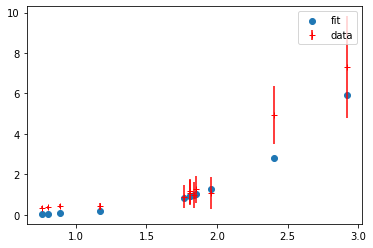

In [110]:
n_ev = 0

mask_ = mask[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
ys = (td[n_ev])[mask_][:,0]
ts = times_diff[n_ev][mask_][:,0]
errs = t_sigma2[n_ev][mask_][:,0]

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask_][:,0], ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
plt.legend()
plt.show()

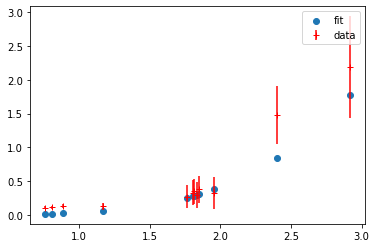

In [111]:
n_ev = 0

mask_ = mask[n_ev,:,:,0].astype(bool)
xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
ys = (td[n_ev])[mask_][:,0]*time2dist
ts = times_diff[n_ev][mask_][:,0]*time2dist
errs = t_sigma2[n_ev][mask_][:,0]*time2dist

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask_][:,0], ts, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
plt.legend()
plt.show()

# Signal Error Plot

In [58]:
cd Notebooks/

/home/rfit/Telescope_Array/Parameters_all/Notebooks


In [113]:
path_old='../../data_01_24.h5'
path_new = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
path = path_old
num=2000
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    if path == path_new:
        dt_bunlde_mask = f['dt_bunlde_mask'][:num]
# norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)
signal_old = data[:,:,:,0:1]
mask_old = data[:,:,:,3:4]

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(2000, 6, 6, 4)


In [114]:
# get LDF from courve reconst
_,LDF,dist_core_old = recon.courve_reconstruction(detectors_rub,t0,theta,phi,courve)

In [115]:
chiL_old, N, error_old = recon.chi2L(S800, LDF, mask_old,signal_old)
s_fit_old = expand_dims(S800)*LDF*mask_old
print(s_fit.shape)

(2000, 6, 6, 1)


In [116]:
path_old='../../data_01_24.h5'
path_new = '/home3/ivkhar/TA/data/MC/bundled/pr_q3_14yr_1745_0010_excl-sat_F_excl-geo_F_take-log-wf-False_bundled.h5'
path = path_new
num=2000
with h5py.File(path,'r') as f:
    print(f.keys())
    data=f['dt_bunlde'][:num,:,:,3:7]
    print(data.shape)
    detectors_rub = f['dt_bunlde'][:num,:,:,:3] * 1.2 #/ 6 # norming
    real_ang = f['mc_params'][:num,4:6]
    recos = f['recos'][:num]
    dt_params =f['dt_params'][:num]
    ev_starts = f['ev_starts'][:num]
    if path == path_new:
        dt_bunlde_mask = f['dt_bunlde_mask'][:num]
# norm_params=norming(data,log=False)
theta = tf.cast(real_ang[:,0:1]/180*3.1415,tf.float32)
phi = tf.cast(real_ang[:,1:2]/180*3.1415,tf.float32)
courve  = tf.cast(recos[:,6:7],tf.float32)
S800 = tf.cast(recos[:,2:3],tf.float32)
chi_rub = tf.cast(recos[:,5:6],tf.float32)
signal_new = data[:,:,:,0:1]
mask_new = data[:,:,:,3:4]

<KeysViewHDF5 ['det_max_params', 'det_max_wf', 'dt_bunlde', 'dt_bunlde_mask', 'dt_mask', 'dt_params', 'ev_ids', 'ev_starts', 'mc_params', 'recos', 'wfs_flat']>
(2000, 6, 6, 4)


In [117]:
_,LDF,dist_core_new = recon.courve_reconstruction(detectors_rub,t0,theta,phi,courve)
chiL_new, N, error_new = recon.chi2L(S800, LDF, mask_new,signal_new)
s_fit_new = expand_dims(S800)*LDF*mask_new
# print(s_fit.shape)

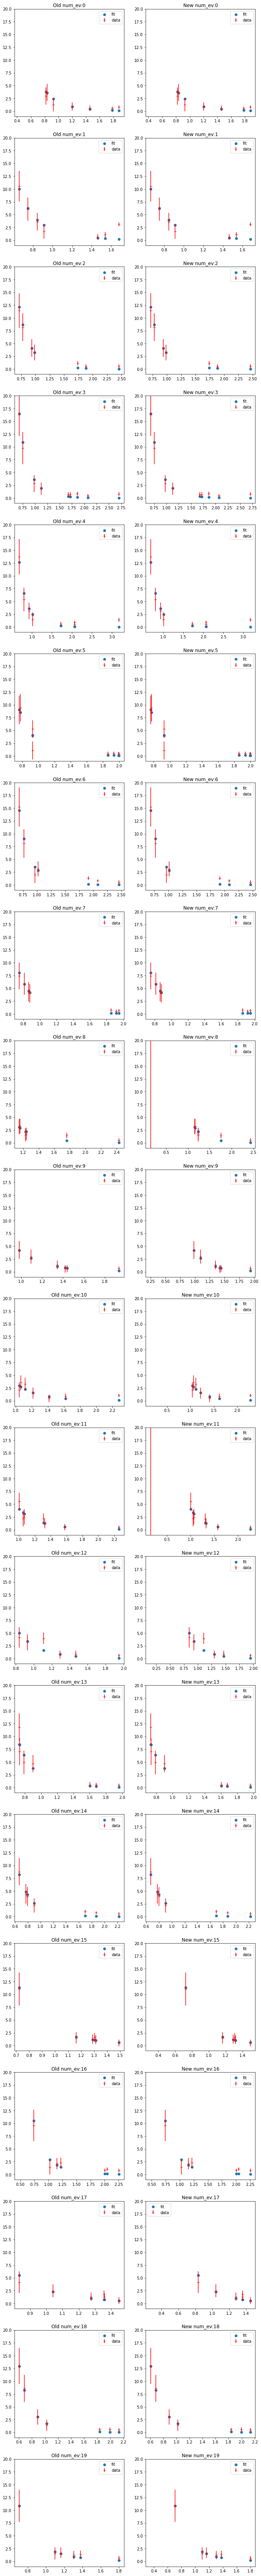

In [120]:
# one plot
n=20
n_s=0
fig,axss =plt.subplots(n,2,figsize = (11,6*n)) 
axs = axss[:,0]
for i, n_ev in enumerate(range(n_s,n_s+n)):
    mask_ = mask_old[n_ev,:,:,0].astype(bool)
    # xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
    ys = s_fit_old[n_ev][mask_][:,0]#*time2dist
    real_s = signal_old[n_ev][mask_][:,0]#*time2dist
    errs = tf.math.sqrt(error_old[n_ev][mask_][:,0])#*time2dist

    #fig, ax = plt.subplots()
    axs[i].errorbar(dist_core_old[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
    axs[i].scatter(dist_core_old[n_ev][mask_][:,0], ys, label='fit')
    axs[i].plot()
    axs[i].set_ylim(-1,20)
    axs[i].legend()
    axs[i].set_title(f'Old num_ev:{n_ev}')
axs = axss[:,1]
for i, n_ev in enumerate(range(n_s,n_s+n)):
    mask_ = mask_new[n_ev,:,:,0].astype(bool)
    # xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
    ys = s_fit_new[n_ev][mask_][:,0]#*time2dist
    real_s = signal_new[n_ev][mask_][:,0]#*time2dist
    errs = tf.math.sqrt(error_new[n_ev][mask_][:,0])#*time2dist

    #fig, ax = plt.subplots()
    axs[i].errorbar(dist_core_new[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
    axs[i].scatter(dist_core_new[n_ev][mask_][:,0], ys, label='fit')
    axs[i].plot()
    axs[i].set_ylim(-1,20)
    axs[i].legend()
    axs[i].set_title(f'New num_ev:{n_ev}')
plt.show()

Old

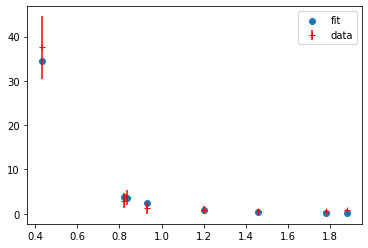

In [96]:
n_ev = 0

mask_ = mask[n_ev,:,:,0].astype(bool)
# xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
ys = s_fit[n_ev][mask_][:,0]#*time2dist
real_s = signal[n_ev][mask_][:,0]#*time2dist
errs = tf.math.sqrt(error[n_ev][mask_][:,0])#*time2dist

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
plt.legend()
plt.show()

New File

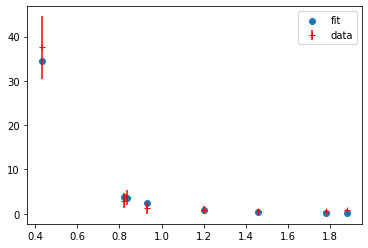

In [87]:
n_ev = 0

mask_ = mask[n_ev,:,:,0].astype(bool)
# xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
ys = s_fit[n_ev][mask_][:,0]#*time2dist
real_s = signal[n_ev][mask_][:,0]#*time2dist
errs = tf.math.sqrt(error[n_ev][mask_][:,0])#*time2dist

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
plt.legend()
plt.show()

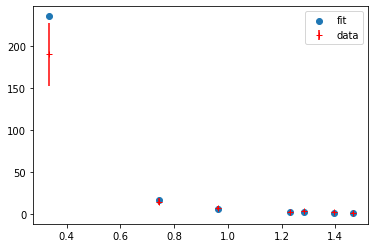

In [77]:
n_ev = -3

mask_ = mask[n_ev,:,:,0].astype(bool)
# xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
ys = s_fit[n_ev][mask_][:,0]#*time2dist
real_s = signal[n_ev][mask_][:,0]#*time2dist
errs = tf.math.sqrt(error[n_ev][mask_][:,0])#*time2dist

#fig, ax = plt.subplots()
plt.errorbar(dist_core[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
plt.scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
plt.legend()
plt.show()

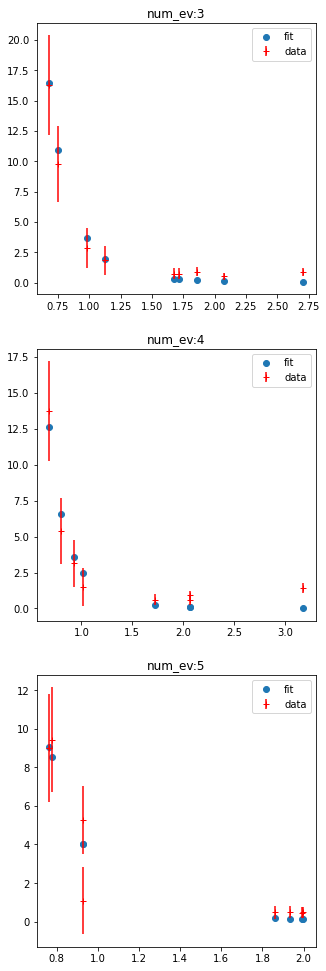

In [78]:
# one plot
fig,axs =plt.subplots(3,1,figsize = (5,17)) 
for i, n_ev in enumerate(range(3,6)):
    mask_ = mask[n_ev,:,:,0].astype(bool)
    # xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
    ys = s_fit[n_ev][mask_][:,0]#*time2dist
    real_s = signal[n_ev][mask_][:,0]#*time2dist
    errs = tf.math.sqrt(error[n_ev][mask_][:,0])#*time2dist

    #fig, ax = plt.subplots()
    axs[i].errorbar(dist_core[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
    axs[i].scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
    axs[i].plot()
    axs[i].legend()
    axs[i].set_title(f'num_ev:{n_ev}')
plt.show()

In [131]:
theta[5]*180/3.14

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([6.5625935], dtype=float32)>

In [124]:
# mean per area
importlib.reload(recon)

<module 'src.reconstruction' from '/home/rfit/Telescope_Array/Parameters_all/src/reconstruction.py'>

In [126]:
chiL, N, error = recon.chi2L(tf.expand_dims(_S800,1), LDF, mask,signal)
s_fit = expand_dims(tf.expand_dims(_S800,1))*LDF*mask но 
print(s_fit.shape)

tf.Tensor(3.0, shape=(), dtype=float32)
(2000, 6, 6, 1)


In [39]:
dist_core[1,:,:,0]*mask[1,:,:,0]

<tf.Tensor: shape=(6, 6), dtype=float32, numpy=
array([[0.       , 0.       , 0.       , 0.       , 0.       , 0.       ],
       [0.       , 0.       , 1.463873 , 1.5368418, 0.       , 0.       ],
       [0.       , 0.       , 0.6623677, 0.7511802, 0.       , 0.       ],
       [0.       , 0.       , 0.8469813, 0.9119431, 0.       , 0.       ],
       [0.       , 0.       , 0.       , 1.6778816, 0.       , 0.       ],
       [0.       , 0.       , 0.       , 0.       , 0.       , 0.       ]],
      dtype=float32)>

In [31]:
signal[1,:,:,0]

array([[ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.680725,  1.0834  ,  0.      ,  0.      ],
       [ 0.      ,  0.      , 10.5486  ,  6.05525 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  3.58595 ,  1.74749 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  3.08809 ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      ,  0.      ,  0.      ,  0.      ]],
      dtype=float32)

In [35]:
theta_[1]*180/3.1415, phi_[1]*180/3.1415

(<tf.Tensor: shape=(1,), dtype=float32, numpy=array([36.0943], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([180.94102], dtype=float32)>)

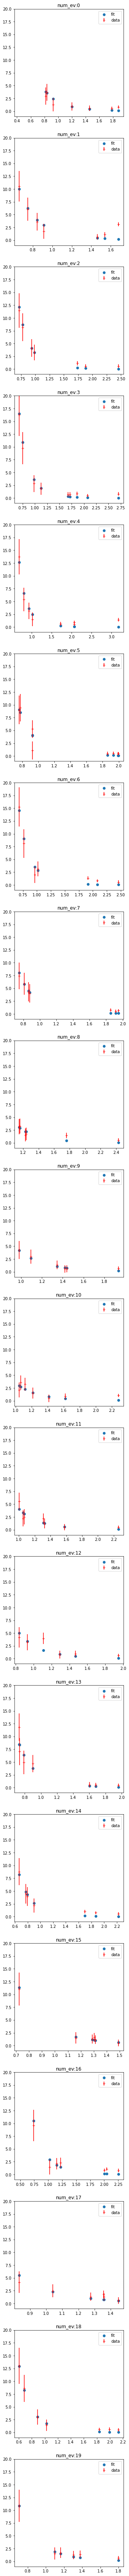

In [97]:
# one plot
n=20
n_s=0
fig,axs =plt.subplots(n,1,figsize = (5,6*n)) 
for i, n_ev in enumerate(range(n_s,n_s+n)):
    mask_ = mask[n_ev,:,:,0].astype(bool)
    # xs = np.sqrt( np.sum( np.power(detectors_rub[n_ev][mask_], 2), axis=-1) )
    ys = s_fit[n_ev][mask_][:,0]#*time2dist
    real_s = signal[n_ev][mask_][:,0]#*time2dist
    errs = tf.math.sqrt(error[n_ev][mask_][:,0])#*time2dist

    #fig, ax = plt.subplots()
    axs[i].errorbar(dist_core[n_ev][mask_][:,0], real_s, yerr=errs, fmt='+', c='red', label='data')
    axs[i].scatter(dist_core[n_ev][mask_][:,0], ys, label='fit')
    axs[i].plot()
    axs[i].set_ylim(-1,20)
    axs[i].legend()
    axs[i].set_title(f'num_ev:{n_ev}')
plt.show()

In [107]:
max_signal = tf.reduce_max(signal,axis = (1,2))
max_signal

<tf.Tensor: shape=(2000, 1), dtype=float32, numpy=
array([[ 37.5351],
       [ 10.5486],
       [ 11.4303],
       ...,
       [190.966 ],
       [ 62.8356],
       [ 69.9043]], dtype=float32)>